In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [5]:
! pip install torchsummary

In [6]:
# Load CIFAR-10 dataset and preprocess
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:01<00:00, 93270884.28it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# Define the VGG16 model architecture
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride = 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
#         x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [8]:
# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG16().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]           4,640
              ReLU-4           [-1, 32, 32, 32]               0
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
         MaxPool2d-7             [-1, 64, 8, 8]               0
            Linear-8                   [-1, 10]          40,970
Total params: 64,554
Trainable params: 64,554
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.97
Params size (MB): 0.25
Estimated Total Size (MB): 1.23
----------------------------------------------------------------


In [10]:
# Training loop
num_epochs = 40
train_loss_history = []
train_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct_predictions / total_predictions
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch 1/40, Loss: 1.4493, Accuracy: 0.4865
Epoch 2/40, Loss: 1.0845, Accuracy: 0.6191
Epoch 3/40, Loss: 0.9584, Accuracy: 0.6658
Epoch 4/40, Loss: 0.8893, Accuracy: 0.6910
Epoch 5/40, Loss: 0.8397, Accuracy: 0.7086
Epoch 6/40, Loss: 0.7911, Accuracy: 0.7254
Epoch 7/40, Loss: 0.7442, Accuracy: 0.7434
Epoch 8/40, Loss: 0.7067, Accuracy: 0.7561
Epoch 9/40, Loss: 0.6643, Accuracy: 0.7699
Epoch 10/40, Loss: 0.6275, Accuracy: 0.7811
Epoch 11/40, Loss: 0.5889, Accuracy: 0.7973
Epoch 12/40, Loss: 0.5574, Accuracy: 0.8084
Epoch 13/40, Loss: 0.5263, Accuracy: 0.8173
Epoch 14/40, Loss: 0.4952, Accuracy: 0.8274
Epoch 15/40, Loss: 0.4679, Accuracy: 0.8373
Epoch 16/40, Loss: 0.4411, Accuracy: 0.8456
Epoch 17/40, Loss: 0.4173, Accuracy: 0.8556
Epoch 18/40, Loss: 0.3934, Accuracy: 0.8625
Epoch 19/40, Loss: 0.3755, Accuracy: 0.8677
Epoch 20/40, Loss: 0.3504, Accuracy: 0.8769
Epoch 21/40, Loss: 0.3335, Accuracy: 0.8829
Epoch 22/40, Loss: 0.3181, Accuracy: 0.8880
Epoch 23/40, Loss: 0.3000, Accuracy: 0.89

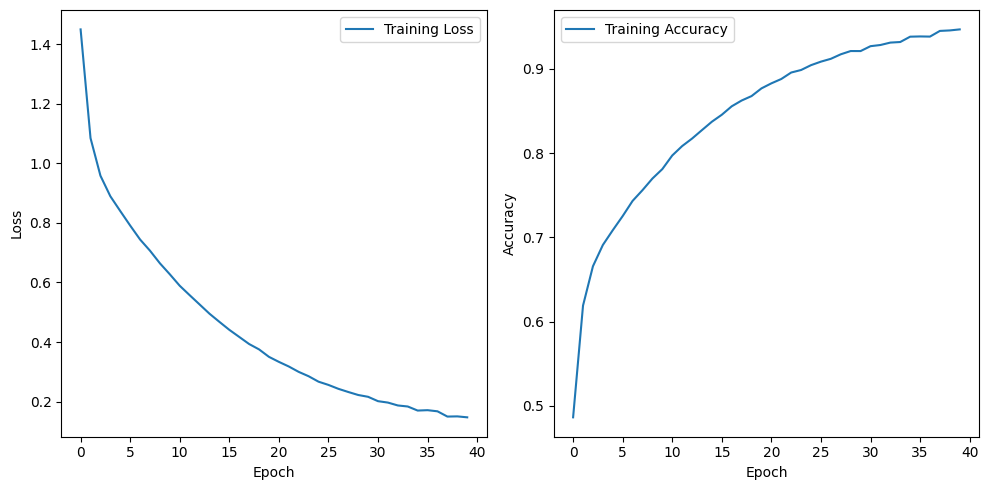

In [11]:
# Plotting training curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
# Evaluation on test dataset
model.eval()
test_correct = 0
test_total = 0

predicted_labels = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_accuracy = test_correct / test_total
print(f"Test Dataset Accuracy: {test_accuracy:.4f}")

Test Dataset Accuracy: 0.6515


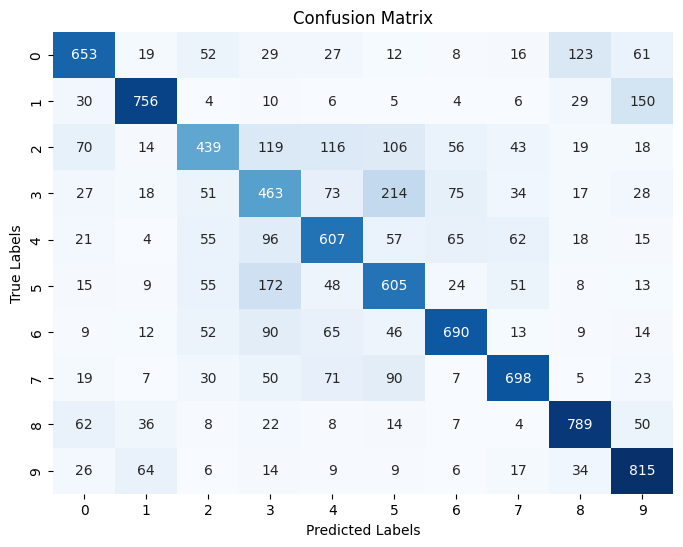

In [13]:
# Plotting confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

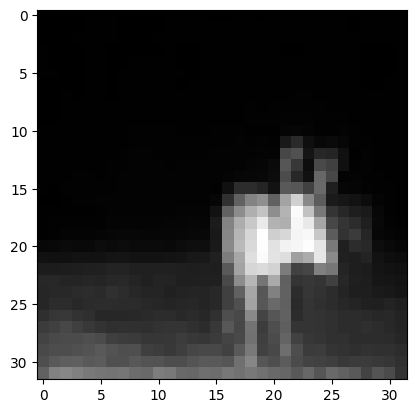

In [26]:
six_img, label = train_dataset[4400]
img = six_img.cpu().numpy()
transposed_image = np.transpose(img, (1, 2, 0))

# Display the image
plt.imshow(transposed_image[:, :, 0], cmap = "gray")  # Displaying as grayscale (assuming the first channel)
plt.show()

In [27]:
model.eval()
six_img = six_img.unsqueeze(0)  # Adds a dimension at index 0
print(model(six_img.to(device)))
print(torch.argmax(model(six_img.to(device)), dim = 1))
model(six_img.to(device))
print("label is ", label)

tensor([[ -2.0058, -15.0277,   5.7919,   5.2941,  17.3872,   2.0151,   0.3930,
           4.2624,  -9.1572, -11.4916]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([4], device='cuda:0')
label is  4


In [29]:
print(img.shape)
print(img[0][1])

(3, 32, 32)
[0.         0.         0.         0.         0.00392157 0.00392157
 0.00392157 0.         0.         0.         0.         0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157 0.00392157
 0.00392157 0.00392157 0.00392157 0.         0.00392157 0.00392157
 0.00392157 0.00392157]


In [30]:
conv = nn.Conv2d(3, 16, 3, padding = 1)
out = conv(six_img)
print(out)

tensor([[[[-1.8124e-01, -1.8124e-01, -1.8124e-01,  ..., -1.8302e-01,
           -1.8274e-01, -1.8112e-01],
          [-1.8124e-01, -1.8124e-01, -1.8261e-01,  ..., -1.8308e-01,
           -1.8313e-01, -1.8288e-01],
          [-1.8065e-01, -1.8110e-01, -1.8223e-01,  ..., -1.8385e-01,
           -1.8300e-01, -1.8394e-01],
          ...,
          [-2.1986e-01, -3.4230e-01, -3.4428e-01,  ..., -2.7624e-01,
           -2.7879e-01, -2.4471e-01],
          [-2.2113e-01, -3.5634e-01, -3.4979e-01,  ..., -2.8166e-01,
           -2.7666e-01, -2.5615e-01],
          [-1.9116e-01, -3.4222e-01, -3.8403e-01,  ..., -3.1028e-01,
           -3.0950e-01, -3.2632e-01]],

         [[-1.3586e-03, -1.3586e-03, -1.3586e-03,  ..., -3.3428e-03,
           -3.9318e-03, -1.5516e-03],
          [-1.3586e-03, -1.3586e-03, -2.8446e-03,  ..., -4.6821e-03,
           -4.8473e-03, -2.5400e-03],
          [ 3.1039e-05, -2.0101e-03, -2.6914e-03,  ..., -4.5334e-03,
           -5.0332e-03, -3.1145e-03],
          ...,
     

In [31]:
with open("cifar_img.h", 'w') as f:
    f.write("#include <iostream> \n")
    f.write("#include <vector> \n")
    f.write("using namespace std; \n")
    f.write("vector<vector<vector<double>>> image = { \n")
    for channel in img:
        f.write("{")
        for i in channel:
            f.write("{")
            for j in i:
                f.write(f"{j}, ")
            f.write("}, \n")
        f.write("},")
    f.write("};")
    

In [25]:
# dense_net.state_dict()
model_parameters = {}
for name, param in model.named_parameters():
    print(name)
    print(param.shape)
    model_parameters[name] = param.cpu().detach().numpy()

value = " { "
# Write parameters to .h file
with open('model_params.h', 'w') as f:
    f.write('#ifndef MODEL_PARAMS_H\n')
    f.write('#define MODEL_PARAMS_H\n\n')
    f.write('#include <vector>\n\n')
    f.write('using namespace std;\n\n')

    for name, param in model_parameters.items():
        if("weight" in name and "classifier" not in name):
            f.write(f'vector<vector<vector<vector<float>>>> {name} = {value}\n')
            for item in param:
                f.write('{')
                for inner_item in item:
                    f.write('    {')
                    for sub_item in inner_item:
                        f.write('{')
                        for sub_sub_item in sub_item:
                            f.write(f'{sub_sub_item}, ')
                        f.write('}, ')
                    f.write('}, \n')
                f.write('}, \n')
            f.write('}; \n')
            
        elif("bias" in name):
            f.write(f'const vector<float> {name} = \n')
            f.write('{\n')
            for item in param:
                f.write(f'{item}, ')
            f.write('};\n')
        else:
            f.write(f"vector<vector<float>> {name} = \n")
            f.write("{ \n")
            for i in param:
                f.write("{ ")
                for j in i:
                    f.write(f"{j}, ")
                f.write("},")
            f.write("}; \n")
                    
    f.write('#endif // MODEL_PARAMS_H\n')

features.0.weight
torch.Size([16, 3, 3, 3])
features.0.bias
torch.Size([16])
features.2.weight
torch.Size([32, 16, 3, 3])
features.2.bias
torch.Size([32])
features.5.weight
torch.Size([64, 32, 3, 3])
features.5.bias
torch.Size([64])
classifier.0.weight
torch.Size([10, 4096])
classifier.0.bias
torch.Size([10])
